In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Imports
# imports
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# @title Data preprocessing
data = np.loadtxt("/content/drive/MyDrive/PRNN/A2/binary_class_classification_data_group_5_train.txt", skiprows=2, dtype='float')
d=5;
X_original=data[:,0:d]
print(np.shape(X_original))
Y_original=data[:,d:d+1]
# Define proportions for train, validation, and test sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 1-train_ratio-val_ratio

# Calculate the sizes of each set
num_samples = len(data)
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)
num_test = num_samples - num_train - num_val

# Split the data into train, validation, and test sets
X_train, y_train = data[:num_train, :-1], data[:num_train, -1:]
X_val, y_val = data[num_train:num_train+num_val, :-1], data[num_train:num_train+num_val, -1:]
X_test, y_test = data[-num_test:, :-1], data[-num_test:, -1:]

(13999, 5)


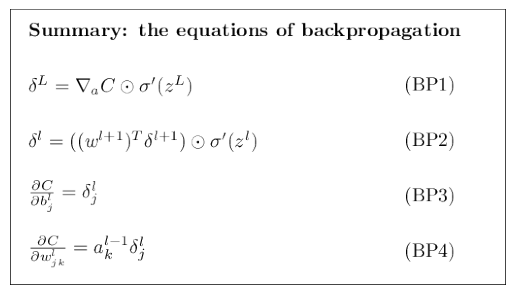

In [ ]:
# @title Equations used for back propagation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread('/content/drive/MyDrive/PRNN/A2/tikz21.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()


In [ ]:
# @title MLP class definition for binary
class MLPBinaryClassifier(object):
    def __init__(self, lr=1e-2, epochs=100, loss_fn='cross_entropy_loss',activation_funcs=['relu', 'relu', 'relu'], layers=[5, 5, 5, 3], l1_reg=0.01,l2_reg=0.01):
        """
        Initialiser function for a class instance

        Inputs:
            lr              -> learning rate
            epochs          -> number of epochs to use during training
            activation_funcs-> list of activation functions for each layer
            layers          -> list containing number of nodes in each layer
            l2_reg          -> L2 regularization parameter
        """
        self.lr = lr
        self.epochs = epochs
        self.activation_funcs = activation_funcs
        self.loss_fn=loss_fn
        self.layers = layers
        self.l2_reg = l2_reg
        self.l1_reg=l1_reg
        self.weights = []
        self.biases = []
        self.train_loss = []
        self.val_loss = []
        self.loss = []
    def __del__(self):
        """
        Destructor function for a class instance
        """
        del self.lr
        del self.epochs
        del self.layers
        del self.biases
        del self.train_loss
        del self.val_loss
        del self.loss

    def _hinge_loss(self, y_true, y_pred):
        """
        Function to compute hinge loss for binary classification

        Inputs:
            y_true -> numpy array of true labels
            y_pred -> numpy array of predicted probabilities
        Output:
            loss value
        """
        return np.mean(np.maximum(0, 1 - y_true * y_pred))

    def _cross_entropy_loss(self, y_true, y_pred):
        """
        Function to compute sigmoid cross entropy loss for binary classification

        Inputs:
            y_true -> numpy array of true labels
            y_pred -> numpy array of predicted probabilities
        Output:
            loss value
        """
        return -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))

    def _weighted_cross_entropy_loss(self, y_true, y_pred, class_weights):
        """
        Function to compute weighted cross entropy loss for binary classification

        Inputs:
            y_true        -> numpy array of true labels
            y_pred        -> numpy array of predicted probabilities
            class_weights -> list of class weights
        Output:
            loss value
        """
        return -np.mean(class_weights[0] * y_true * np.log(y_pred + 1e-8) + class_weights[1] * (1 - y_true) * np.log(1 - y_pred + 1e-8))

    def _loss(self, y_true, y_pred, loss_fn):
        """
        Function to compute loss based on the specified loss function

        Inputs:
            y_true   -> numpy array of true labels
            y_pred   -> numpy array of predicted values
            loss_fn  -> string indicating the loss function to be used
                        Options: 'hinge_loss', 'cross_entropy_loss', 'mse_loss'
        Output:
            loss value
        """
        if loss_fn == 'hinge_loss':
            hinge_loss = self._hinge_loss(y_true, y_pred)
            # Compute L1 regularization term
            l1_reg_term = self.l1_reg * sum(np.sum(np.abs(w)) for w in self.weights)
            # Compute L2 regularization term
            l2_reg_term = 0.5 * self.l2_reg * sum(np.sum(np.square(w)) for w in self.weights)
            # Add regularization terms to the loss
            total_loss = hinge_loss + l1_reg_term + l2_reg_term
            return total_loss
        elif loss_fn == 'cross_entropy_loss':
            cross_entropy_loss = self._cross_entropy_loss(y_true, y_pred)
            # Compute L1 regularization term
            l1_reg_term = self.l1_reg * sum(np.sum(np.abs(w)) for w in self.weights)
            # Compute L2 regularization term
            l2_reg_term = 0.5 * self.l2_reg * sum(np.sum(np.square(w)) for w in self.weights)
            # Add regularization terms to the loss
            total_loss = cross_entropy_loss + l1_reg_term + l2_reg_term
            return total_loss
        elif loss_fn == 'mse_loss':
            mse_loss = 0.5 * np.square(y_true - y_pred)
            # Compute L1 regularization term
            l1_reg_term = self.l1_reg * sum(np.sum(np.abs(w)) for w in self.weights)
            # Compute L2 regularization term
            l2_reg_term = 0.5 * self.l2_reg * sum(np.sum(np.square(w)) for w in self.weights)
            # Add regularization terms to the loss
            total_loss = np.mean(mse_loss) + l1_reg_term + l2_reg_term
            return total_loss
        else:
            raise ValueError("Invalid loss function. Supported options: 'hinge_loss', 'cross_entropy_loss', 'mse_loss'")





    def _derivative_hinge_loss(self, y_true, y_pred):
        """
        Function to compute the derivative of hinge loss for binary classification

        Inputs:
            y_true -> numpy array of true labels
            y_pred -> numpy array of predicted probabilities
        Output:
            derivative of loss
        """
        return np.where(y_true * y_pred < 1, -y_true, 0)

    def _derivative_cross_entropy_loss(self, y_true, y_pred):
        """
        Function to compute the derivative of sigmoid cross entropy loss for binary classification

        Inputs:
            y_true -> numpy array of true labels
            y_pred -> numpy array of predicted probabilities
        Output:
            derivative of loss
        """
        return y_pred - y_true

    def _derivative_weighted_cross_entropy_loss(self, y_true, y_pred, class_weights):
        """
        Function to compute the derivative of weighted cross entropy loss for binary classification

        Inputs:
            y_true        -> numpy array of true labels
            y_pred        -> numpy array of predicted probabilities
            class_weights -> list of class weights
        Output:
            derivative of loss
        """
        return class_weights[0] * (y_pred - y_true) * y_true + class_weights[1] * (y_pred - y_true) * (1 - y_true)

    def _derivative_loss(self, y_true, y_pred, loss_fn):
        """
        Function to compute the derivative of the loss function based on the specified loss function

        Inputs:
            y_true   -> numpy array of true labels
            y_pred   -> numpy array of predicted probabilities
            loss_fn  -> string specifying the loss function ('hinge_loss', 'cross_entropy_loss', 'weighted_cross_entropy_loss')
        Output:
            derivative of loss
        """
        if loss_fn == 'hinge_loss':
            return self._derivative_hinge_loss(y_true, y_pred)
        elif loss_fn == 'cross_entropy_loss':
            return self._derivative_cross_entropy_loss(y_true, y_pred)



    def _sigmoid(self, z):
        """
        Function to compute sigmoid activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined activation
        """
        return 1 / (1 + np.exp(-z))

    def _derivative_sigmoid(self, z):
        """
        Function to compute the derivative of the sigmoid activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined derivative of activation
        """
        return self._sigmoid(z) * (1 - self._sigmoid(z))

    def _linear(self, z):
        """
        Function to compute linear activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined activation
        """
        return z

    def _derivative_linear(self, z):
        """
        Function to compute the derivative of the linear activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined derivative of activation
        """
        return np.ones(z.shape)

    def _relu(self, z):
        """
        Function to compute ReLU activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined activation
        """
        return np.maximum(0, z)

    def _derivative_relu(self, z):
        """
        Function to compute the derivative of the ReLU activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined derivative of activation
        """
        return np.where(z > 0, 1, 0)

    def _tanh(self, z):
        """
        Function to compute Hyperbolic Tangent (tanh) activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined activation
        """
        return np.tanh(z)

    def _derivative_tanh(self, z):
        """
        Function to compute the derivative of the Hyperbolic Tangent (tanh) activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined derivative of activation
        """
        return 1 - np.tanh(z) ** 2

    def _activate(self, z, activation_func):
        """
        Function to apply activation function based on given activation_func parameter

        Inputs:
            z -> input dot product w*x + b
            activation_func -> string representing the activation function ('sigmoid', 'linear', 'relu', 'tanh')
        Output:
            determined activation
        """
        if activation_func == 'sigmoid':
            return self._sigmoid(z)
        elif activation_func == 'linear':
            return self._linear(z)
        elif activation_func == 'relu':
            return self._relu(z)


        elif activation_func == 'tanh':
                return self._tanh(z)
        else:
            # Default to linear activation
            return self._linear(z)

    def _derivative_activate(self, z, activation_func):
        """
        Function to compute the derivative of the activation function

        Inputs:
            z -> input dot product w*x + b
            activation_func -> string representing the activation function ('sigmoid', 'linear', 'relu', 'tanh')
        Output:
            determined derivative of activation
        """
        if activation_func == 'sigmoid':
            return self._derivative_sigmoid(z)
        elif activation_func == 'linear':
            return self._derivative_linear(z)
        elif activation_func == 'relu':
            return self._derivative_relu(z)
        elif activation_func == 'tanh':
            return self._derivative_tanh(z)
        else:
            # Default to derivative of linear activation
            return self._derivative_linear(z)

    def _forward_pass(self, X):
        """
        Function to perform forward pass through the network

        Input:
            X -> numpy array of input predictive features with assumed shape [number_features, number_samples]
        Output:
            list of activations & derivatives for each layer
        """
        # record from input layer
        input_to_layer = np.copy(X)
        activations = [input_to_layer]
        derivatives = [np.zeros(X.shape)]

        for i in range(len(self.layers) - 2):
            # Compute the input to the current hidden layer

            z_i = np.matmul(self.weights[i], input_to_layer) + self.biases[i]
            # Apply activation function to the input
            input_to_layer = self._activate(z_i, self.activation_funcs[i])
            # Store activation and derivative
            activations.append(input_to_layer)
            derivatives.append(self._derivative_activate(z_i, self.activation_funcs[i]))

        # Compute the input to the output layer
        z_i = np.matmul(self.weights[-1], input_to_layer) + self.biases[-1]
        # Apply linear activation function for the output layer
        input_to_layer = self._activate(z_i, self.activation_funcs[-1])
        # Store activation and derivative for the output layer
        activations.append(input_to_layer)
        derivatives.append(self._derivative_activate(z_i, self.activation_funcs[-1]))
        # return results
        return activations, derivatives

    def _backward_pass(self, activations, derivatives, y):
        """
        Function to perform backward pass through the network

        Inputs:
            activations -> list of activations from each layer in the network
            derivatives -> list of derivatives from each layer in the network
            y           -> numpy array of target values
                          with assumed shape [output dimension, number_samples]
        Output:
            list of numpy arrays containing the derivates of the loss function wrt layer weights
        """
        # record loss
        self.loss.append((1 / y.shape[1]) * np.sum(self._loss(y, activations[-1],self.loss_fn)))

        # Initialize lists to store gradients
        dl_dw = []
        dl_db = []

        # Output layer gradients
        #BP1 equation
        dl_dy = self._derivative_loss(y, activations[-1],self.loss_fn)
        dl_dz = np.multiply(dl_dy, derivatives[-1])
        #BP4 equation
        dl_dw.append((1 / y.shape[1]) * np.matmul(dl_dz, activations[-2].T))
        #BP3 equation
        dl_db.append((1 / y.shape[1]) * np.sum(dl_dz, axis=1))


        # Backpropagation through hidden layers
        for i in range(len(self.layers) - 2, 0, -1):
            # Compute gradients
            #BP2 equation
            dl_dy = np.matmul(self.weights[i].T, dl_dz)
            dl_dz = np.multiply(dl_dy, derivatives[i])
            #BP4 equation
            dl_dw.append((1 / y.shape[1]) * np.matmul(dl_dz, activations[i - 1].T))
            #BP3 equation
            dl_db.append((1 / y.shape[1]) * np.sum(dl_dz, axis=1))

        # Reverse the lists to maintain the order
        dl_dw = dl_dw[::-1]
        dl_db = dl_db[::-1]

        # Return gradients
        return dl_dw, dl_db

    def _update_weights(self, dl_dw, dl_db):
        """
        Function to apply update rule to model with L1 and L2 regularization

        Inputs:
            dl_dw -> list of numpy arrays containing loss derivatives wrt weights
            dl_db -> list of numpy arrays containing loss derivatives wrt biases
        """
        # Update weights and biases for input layer with L1 and L2 regularization
        self.weights[0] -= self.lr * (dl_dw[0] + self.l1_reg * np.sign(self.weights[0]) + self.l2_reg * self.weights[0])
        self.biases[0] -= self.lr * dl_db[0].reshape(-1, 1)

        # Update weights and biases for hidden layers with L1 and L2 regularization
        for i in range(1, len(self.layers) - 1):
            self.weights[i] -= self.lr * (dl_dw[i] + self.l1_reg * np.sign(self.weights[i]) + self.l2_reg * self.weights[i])
            self.biases[i] -= self.lr * dl_db[i].reshape(-1, 1)

        # Update weights and biases for output layer with L1 and L2 regularization
        self.weights[-1] -= self.lr * (dl_dw[-1] + self.l1_reg * np.sign(self.weights[-1]) + self.l2_reg * self.weights[-1])
        self.biases[-1] -= self.lr * dl_db[-1].reshape(-1, 1)


    def fit(self, X_train, y_train, X_val, y_val, batch_size=32, early_stopping=False, patience=50):
        """
        Function to train a class instance with early stopping based on validation loss

        Inputs:
            X_train -> numpy array of input predictive features for training
                      with assumed shape [number_samples, number_features]
            y_train -> numpy array of target values for training
                      with assumed shape [number_samples, output dimension]
            X_val   -> numpy array of input predictive features for validation
                      with assumed shape [number_samples, number_features]
            y_val   -> numpy array of target values for validation
                      with assumed shape [number_samples, output dimension]
            batch_size -> size of each batch for batch training
        """
        # Initialize the model parameters
        self.weights.clear()
        self.biases.clear()
        self.loss.clear()
        for idx in range(len(self.layers) - 1):
            self.weights.append(np.random.randn(self.layers[idx + 1], self.layers[idx]) * 0.1)
            self.biases.append(np.random.randn(self.layers[idx + 1], 1) * 0.1)

        train_losses = []  # List to store training losses
        val_losses = []    # List to store validation losses
        train_accuracies = []  # List to store training accuracies
        val_accuracies = []    # List to store validation accuracies
        best_val_loss = float('inf')  # Initialize best validation loss to positive infinity
        best_epoch = 0  # Initialize variable to store the epoch with the best validation loss

        num_samples = X_train.shape[0]
        num_batches = num_samples // batch_size
        epochs_without_improvement = 0

        # Loop through each epoch
        for epoch in range(1, self.epochs + 1):
            # Shuffle the training data for each epoch
            shuffled_indices = np.random.permutation(num_samples)
            X_train_shuffled = X_train[shuffled_indices]
            y_train_shuffled = y_train[shuffled_indices]

            # Loop through each batch
            for batch in range(num_batches):
                # Get the start and end indices for the current batch
                start_idx = batch * batch_size
                end_idx = min((batch + 1) * batch_size, num_samples)

                # Extract the current batch of training data
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]

                # Do forward pass through the network for the current batch
                train_activations, train_derivatives = self._forward_pass(X_batch.T)

                # Do backward pass through the network for the current batch
                train_dl_dw, train_dl_db = self._backward_pass(train_activations, train_derivatives, y_batch.T)
                # Update weights for the current batch
                self._update_weights(train_dl_dw, train_dl_db)

            # Compute training loss for the entire epoch
            train_activations, _ = self._forward_pass(X_train.T)
            train_loss = (self._loss(y_train.T, train_activations[-1], self.loss_fn))
            train_losses.append(train_loss)

            # Compute validation loss and accuracy for the entire epoch
            val_activations, _ = self._forward_pass(X_val.T)
            val_loss = (self._loss(y_val.T, val_activations[-1], self.loss_fn))
            val_losses.append(val_loss)

            # Compute accuracy for training and validation data
            train_accuracy = np.mean((train_activations[-1].T >= 0.5) == y_train)
            val_accuracy = np.mean((val_activations[-1].T >= 0.5) == y_val)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            # Print training and validation loss and accuracy for the current epoch
           # print(f"Epoch {epoch}/{self.epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f} - Training Accuracy: {train_accuracy:.4f} - Validation Accuracy: {val_accuracy:.4f}")

            # Check if early stopping is enabled
            if early_stopping:
                # Check if validation loss has improved
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_epoch = epoch
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1
                    if epochs_without_improvement >= patience:
                        print(f"Validation loss hasn't improved for {patience} epochs. Early stopping.")
                        break

        # Plot the training and validation losses
        plt.plot(range(1, epoch + 1), train_losses, label='Training Loss')
        plt.plot(range(1, epoch + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        # Plot the training and validation accuracies
        plt.plot(range(1, epoch + 1), train_accuracies, label='Training Accuracy')
        plt.plot(range(1, epoch + 1), val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.show()





    def predict(self, X):
        """
        Function to produce predictions from a trained class instance

        Input:
            X -> numpy array of input predictive features with assumed shape [number_samples, number_features]
        Output:
            numpy array of model predictions
        """
        # do forward pass through the network
        activations, _ = self._forward_pass(X.T)
        # return binary predictions based on threshold 0.5
        return (activations[-1].T >= 0.5).astype(int)

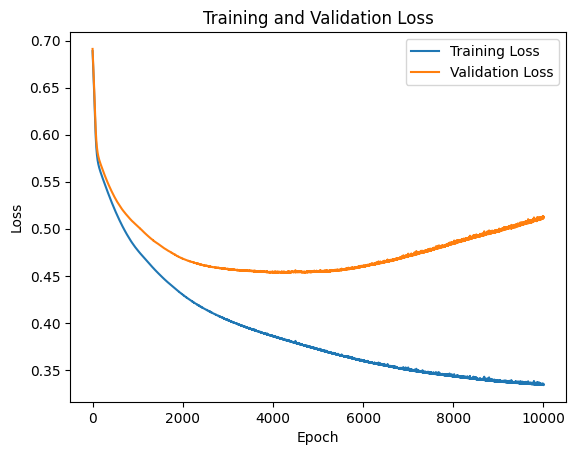

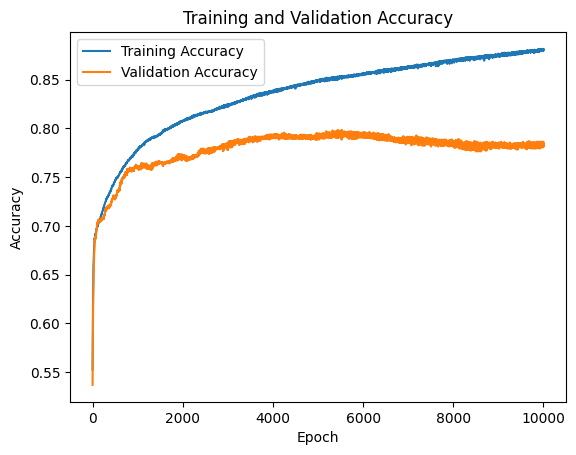

In [ ]:
# train the regressor
model = MLPBinaryClassifier(lr=0.001,epochs=10000,loss_fn='cross_entropy_loss',activation_funcs=['relu','relu', 'sigmoid'], layers=[X_train.shape[1],128,32,  y_train.shape[1]],l1_reg=0.0,l2_reg=0.0)
model.fit(X_train,y_train,X_val,y_val,batch_size=32,early_stopping=False)

In [ ]:
y_pred=model.predict(X_test)
print(y_pred)

[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [1]]


<ipython-input-48-22cf58e39e1f>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cm[int(true_label), int(pred_label)] += 1 # Ensure integer indices


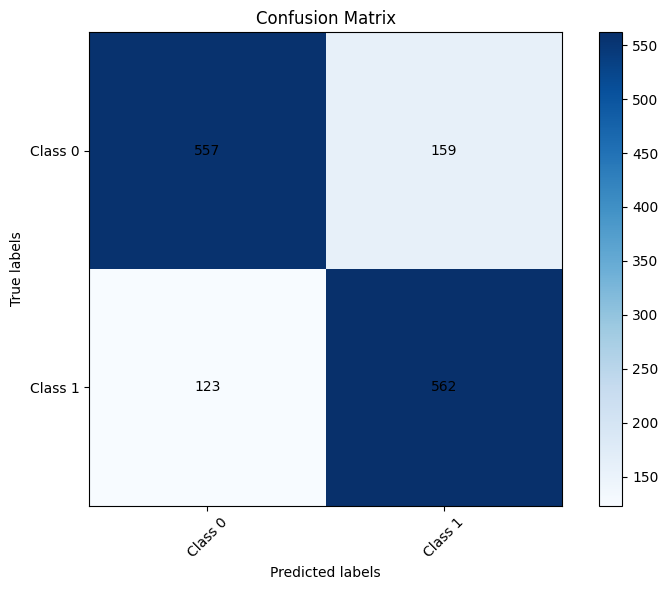

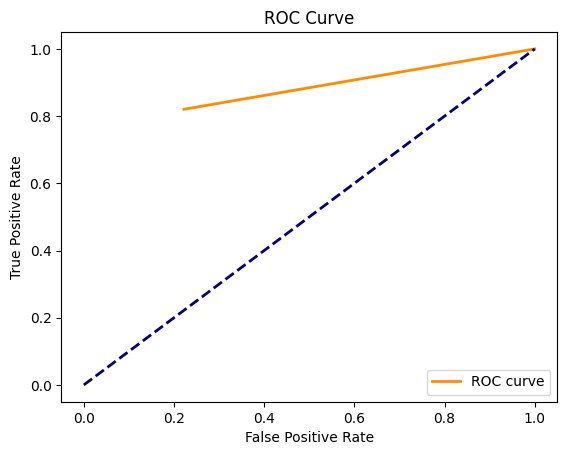

In [ ]:
import numpy as np

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)
    """
    Function to compute the confusion matrix

    Inputs:
        y_true -> numpy array of true labels
        y_pred -> numpy array of predicted labels
        num_classes -> number of unique classes
    Output:
        confusion matrix
    """

def confusion_matrix1(y_true, y_pred, num_classes):
    """
    Function to compute the confusion matrix

    Inputs:
        y_true -> numpy array of true labels
        y_pred -> numpy array of predicted labels
        num_classes -> number of unique classes
    Output:
        confusion matrix
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        cm[int(true_label), int(pred_label)] += 1 # Ensure integer indices
    return cm

def plot_confusion_matrix1(cm, class_labels):
    """
    Function to plot the confusion matrix

    Inputs:
        cm -> confusion matrix
        class_labels -> list of class labels
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center')

    plt.tight_layout()
    plt.show()

# Example usage:
# Define your true labels, predicted labels, and number of classes

num_classes = 2
class_labels = ['Class 0', 'Class 1']

# Compute confusion matrix
cm = confusion_matrix1(y_test, y_pred, num_classes)
plot_confusion_matrix1(cm, class_labels)
def f1_score(y_true, y_pred):
    cm = confusion_matrix1(y_true, y_pred, num_classes)
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1
def roc_curve1(y_true, y_pred, thresholds):
    tpr = []
    fpr = []
    num_positives = np.sum(y_true)
    num_negatives = len(y_true) - num_positives

    for threshold in thresholds:
        y_pred_binary = (y_pred >= threshold).astype(int)
        tp = np.sum((y_true == 1) & (y_pred_binary == 1))
        fp = np.sum((y_true == 0) & (y_pred_binary == 1))
        tpr.append(tp / num_positives)
        fpr.append(fp / num_negatives)

    return np.array(fpr), np.array(tpr)
# Plot ROC curve
def plot_roc_curve1(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Assuming you have computed fpr and tpr using roc_curve1 function
thresholds = np.linspace(0, 1, 1000)  # Generate 100 thresholds from 0 to 1
fpr, tpr = roc_curve1(y_test, y_pred, thresholds)
plot_roc_curve1(fpr, tpr)


Confusion matrix
[[557 159]
 [123 562]]


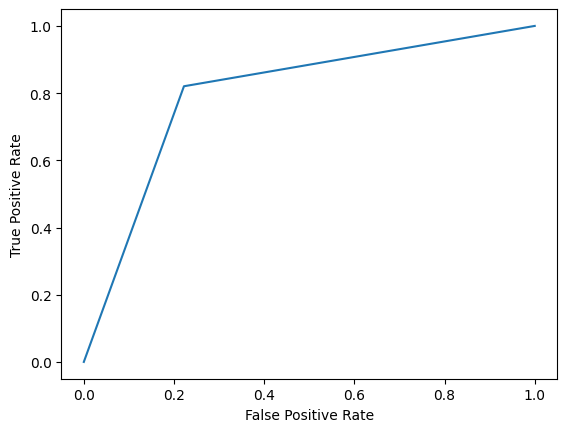

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(y_test, y_pred)
cf_mat = confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(cf_mat)
